In [57]:
import json
import argparse
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import numpy as np

In [2]:
def read_json(file_path):
    """Read a JSON file and return the data."""
    with open(file_path, 'r') as f:
        return json.load(f)

In [4]:
def find_ids_with_elements(dendrogram, gt_solution):
    """
    Find the IDs in the dendrogram that contain each element in gt_solution.

    Args:
        dendrogram (dict): The nested dictionary encoding the tree.
        gt_solution (list): List of strings to find in the tree.

    Returns:
        dict: A dictionary mapping each gt_solution element to its corresponding ID.
    """
    id_map = {}

    def traverse(node, node_id):
        if isinstance(node["children"], list) and all(isinstance(child, dict) for child in node["children"]):
            for i, child in enumerate(node["children"]):
                traverse(child, node_id + [i])
        elif isinstance(node["children"], list) and all(isinstance(child, str) for child in node["children"]):  # Leaf node
            for element in node["children"]:
                if element in gt_solution:
                    id_map[element] = node_id

    traverse(dendrogram, [])
    return id_map

In [6]:
def analyze_solution_ids(gt_solution_ids):
    """
    Analyze the frequency of elements in each ID.

    Args:
        gt_solution_ids (dict): A mapping of gt_solution elements to their IDs.

    Returns:
        dict: A dictionary with IDs as keys and frequency counts of elements as values.
    """
    id_counter = defaultdict(list)

    for element, node_id in gt_solution_ids.items():
        id_counter[tuple(node_id)].append(element)

    frequency_analysis = {}
    for node_id, elements in id_counter.items():
        frequency_analysis[node_id] = len(elements)

    return frequency_analysis

In [62]:
def plot_tree_with_dendrogram(dendrogram, analysis):
    """
    Plot the dendrogram using matplotlib and annotate leaves with gt_solution frequencies.

    Args:
        dendrogram (dict): The nested dictionary representing the dendrogram.
        analysis (dict): A mapping of IDs to frequencies for gt_solution.
    """
    # Collect all leaf nodes to determine positions
    leaf_positions = []

    def collect_leaves(node, x, dx):
        if isinstance(node["children"], list) and all(isinstance(child, dict) for child in node["children"]):
            left_x = x - dx / 2
            right_x = x + dx / 2
            collect_leaves(node["children"][0], left_x, dx / 2)
            collect_leaves(node["children"][1], right_x, dx / 2)
        elif isinstance(node["children"], list) and all(isinstance(child, str) for child in node["children"]):
            leaf_positions.append(x)

    def plot_node(node, x, y, dx):
        if isinstance(node["children"], list) and all(isinstance(child, dict) for child in node["children"]):
            # Intermediate node
            left_child, right_child = node["children"]
            left_x = x - dx / 2
            right_x = x + dx / 2
            plt.plot([x, left_x], [y, y - 1], color="black")
            plt.plot([x, right_x], [y, y - 1], color="black")
            plot_node(left_child, left_x, y - 1, dx / 2)
            plot_node(right_child, right_x, y - 1, dx / 2)
        elif isinstance(node["children"], list) and all(isinstance(child, str) for child in node["children"]):
            # Leaf node
            freq = analysis.get(tuple(node.get("id", [])), 0)
            leaf_y_level = min(leaf_positions) - 1  # All leaves at the same y-level
            color_norm = Normalize(vmin=min(analysis.values()), vmax=max(analysis.values()))
            cmap = plt.cm.viridis
            color = cmap(color_norm(freq))
            plt.text(x, leaf_y_level, str(freq), fontsize=10, ha="center", va="top", color=color, rotation=90)

    # Determine leaf positions for consistent y-level
    collect_leaves(dendrogram, 0, 10)
    plt.figure(figsize=(12, 6))
    plot_node(dendrogram, 0, 0, 10)

    # Add color bar
    sm = ScalarMappable(cmap=plt.cm.viridis, norm=Normalize(vmin=min(analysis.values()), vmax=max(analysis.values())))
    sm.set_array([])
    plt.colorbar(sm, orientation="horizontal", label="Frequency")

    plt.axis("off")
    plt.show()

In [13]:
gt_filename = "/home/jwc/approx-topk/Temp/Results/UsedCars/gt_small.json"
dendrogram_index = "/home/jwc/approx-topk/Temp/Index/UsedCars/dendrogram.json"

In [14]:
gt_data = read_json(gt_filename)
dendrogram_data = read_json(dendrogram_index)

In [15]:
gt_solution = gt_data.get("gt_solution", [])

In [16]:
gt_solution_ids = find_ids_with_elements(dendrogram_data, gt_solution)

In [19]:
analysis = analyze_solution_ids(gt_solution_ids)
sorted_analysis = sorted(analysis.items(), key=lambda x: -x[1])

In [64]:
analysis

{(0, 0, 1, 1, 1, 0, 1, 0, 0): 1,
 (0, 0, 1, 1, 1, 1, 0, 0): 5,
 (1, 0, 1, 1, 1, 0, 0, 0): 11,
 (1, 0, 1, 1, 1, 0, 0, 1): 5,
 (1, 0, 1, 1, 1, 0, 1, 0): 29,
 (1, 0, 1, 1, 1, 0, 1, 1): 1,
 (1, 0, 1, 1, 1, 1, 0, 0, 0, 0): 15,
 (1, 0, 1, 1, 1, 1, 0, 0, 0, 1): 18,
 (1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0): 1,
 (1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0): 2,
 (1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0): 28,
 (1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0): 10,
 (1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1): 13,
 (1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1): 1,
 (1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0): 1,
 (1, 1, 0, 1, 0, 1, 0, 0, 0): 3,
 (1, 1, 0, 1, 0, 1, 0, 0, 1): 6,
 (1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0): 1,
 (1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1): 9,
 (1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0): 1,
 (1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0): 1,
 (1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0): 16,
 (1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1): 6,
 (1, 1, 0, 1, 0, 1, 0, 1, 1, 0): 5,
 (1, 1, 0, 1, 0, 1, 

In [20]:
sorted_analysis

[((1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0), 38),
 ((1, 0, 1, 1, 1, 0, 1, 0), 29),
 ((1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0), 28),
 ((1, 0, 1, 1, 1, 1, 0, 0, 0, 1), 18),
 ((1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0), 16),
 ((1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0), 16),
 ((1, 0, 1, 1, 1, 1, 0, 0, 0, 0), 15),
 ((1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1), 13),
 ((1, 0, 1, 1, 1, 0, 0, 0), 11),
 ((1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0), 10),
 ((1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1), 9),
 ((1, 1, 0, 1, 0, 1, 0, 0, 1), 6),
 ((1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1), 6),
 ((0, 0, 1, 1, 1, 1, 0, 0), 5),
 ((1, 0, 1, 1, 1, 0, 0, 1), 5),
 ((1, 1, 0, 1, 0, 1, 0, 1, 1, 0), 5),
 ((1, 1, 0, 1, 0, 1, 0, 0, 0), 3),
 ((1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0), 3),
 ((1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0), 2),
 ((0, 0, 1, 1, 1, 0, 1, 0, 0), 1),
 ((1, 0, 1, 1, 1, 0, 1, 1), 1),
 ((1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0), 1),
 ((1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1), 1),
 ((1, 0, 1, 1, 1, 1, 1, 1, 1,

/tmp/ipykernel_421791/3002652824.py:48: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, orientation="horizontal", label="Frequency")


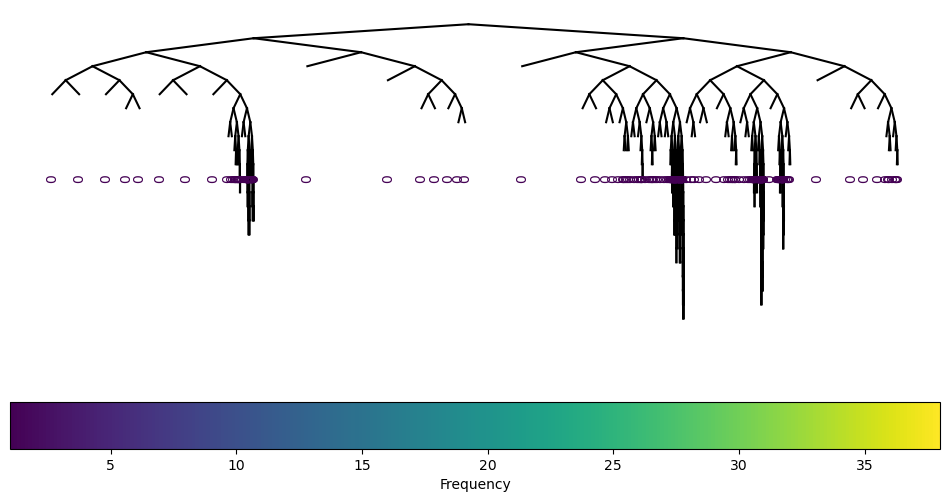

In [63]:
plot_tree_with_dendrogram(dendrogram_data, analysis)

In [71]:
def print_leaf_depths_from_json(json_file_path: str):
    """
    Reads a JSON file representing a tree, performs a DFS traversal, and prints the number of leaves
    with each unique depth.

    :param json_file_path: Path to the JSON file encoding the tree.
    """
    with open(json_file_path, 'r') as f:
        tree = json.load(f)

    depth_counts = {}

    def dfs(node, depth):
        # Check if this is a leaf node (children is a list of strings)
        if isinstance(node['children'], list) and all(isinstance(child, str) for child in node['children']):
            if depth not in depth_counts:
                depth_counts[depth] = 0
            depth_counts[depth] += 1
            return

        # Recursively visit children if not a leaf
        for child in node['children']:
            dfs(child, depth + 1)

    dfs(tree, 0)

    for depth, count in sorted(depth_counts.items()):
        print(f"Depth {depth}: {count} leaves")

In [74]:
print_leaf_depths_from_json('/home/jwc/approx-topk/Temp/Index/UsedCars/dendrogram-balanced.json')

TypeError: list indices must be integers or slices, not str